# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
import shutil
import scipy.io
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import itertools
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
from tensorflow.keras import mixed_precision
import json
import pickle

In [ ]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto, InteractiveSession
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import layers, regularizers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
mixed_precision.set_global_policy('mixed_float16')

# เตรียม Dataset

In [ ]:
zip_path = "/content/drive/MyDrive/Datasets/stanford_car_dataset_by_classes.zip"
extract_path = "/content/Dataset"

# สร้างโฟลเดอร์ถ้ายังไม่มี
os.makedirs(extract_path, exist_ok=True)

# แตกไฟล์
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
DATASET_DIR = "/content/Dataset"

TRAIN_DIR = os.path.join(DATASET_DIR, "car_data", "car_data", "train")
TEST_DIR = os.path.join(DATASET_DIR, "car_data", "car_data", "test")

📊 ตัวอย่างจำนวนภาพใน train:
                                        Class  Train Images
140                       GMC Savana Van 2012            68
131                   Chrysler 300 SRT-8 2010            49
173  Mercedes-Benz 300-Class Convertible 1993            48
135              Mitsubishi Lancer Sedan 2012            48
82                Chevrolet Corvette ZR1 2012            47
78                         Jaguar XK XKR 2012            47
69                     Dodge Durango SUV 2007            46
92                  Suzuki Kizashi Sedan 2012            46
80                         Ford GT Coupe 2006            46
100                Eagle Talon Hatchback 1998            46


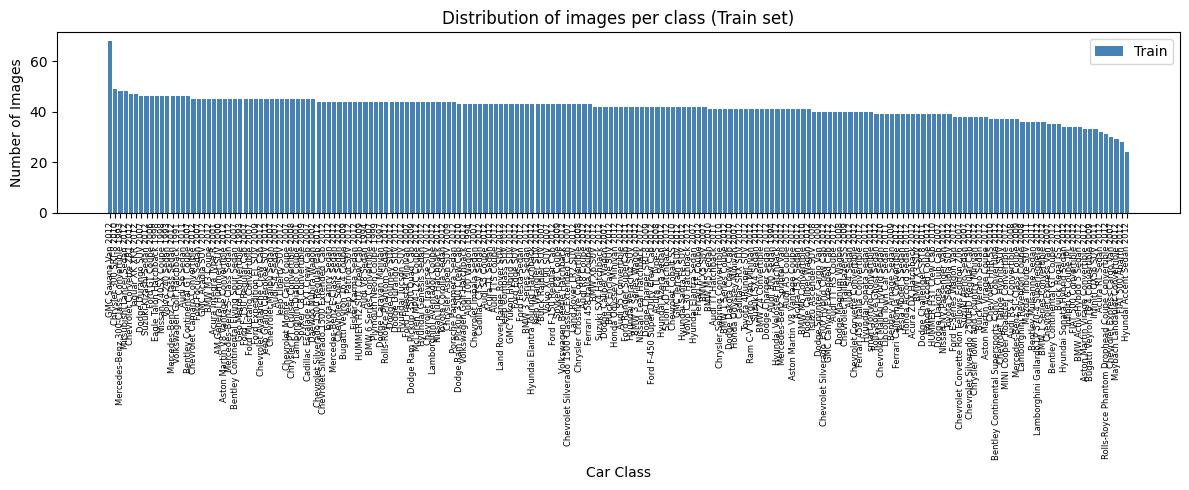


รวมทั้งหมด:
Train: 8144 รูป
รวมทั้งหมด 196 คลาส


In [ ]:
# นับจำนวนภาพในแต่ละโฟลเดอร์
train_counts = Counter()
for cls in os.listdir(TRAIN_DIR):
    cls_path = os.path.join(TRAIN_DIR, cls)
    if os.path.isdir(cls_path):
        n_images = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        train_counts[cls] = n_images

# สร้าง DataFrame
train_df = pd.DataFrame(train_counts.items(), columns=["Class", "Train Images"])
train_df = train_df.sort_values("Train Images", ascending=False)

# แสดงตัวอย่าง
print("📊 ตัวอย่างจำนวนภาพใน train:")
print(train_df.head(10))

# พล็อตกราฟ
plt.figure(figsize=(12, 5))
plt.bar(train_df["Class"], train_df["Train Images"], color="steelblue", label="Train")
plt.title("Distribution of images per class (Train set)")
plt.xlabel("Car Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=90, fontsize=6)
plt.legend()
plt.tight_layout()
plt.show()

print("\nรวมทั้งหมด:")
print(f"Train: {train_df['Train Images'].sum()} รูป")
print(f"รวมทั้งหมด {len(train_df)} คลาส")

In [ ]:
ROOT_DIR = "/content/Dataset/car_data/car_data/train"
OUTPUT_DIR = "/content/FinalDataset"
TRAIN_OUT = os.path.join(OUTPUT_DIR, "train")
VAL_OUT = os.path.join(OUTPUT_DIR, "val")

TRAIN_RATIO = 0.75
VAL_RATIO = 0.25

random.seed(42)  # reproducible

# สร้างโฟลเดอร์ปลายทาง
os.makedirs(TRAIN_OUT, exist_ok=True)
os.makedirs(VAL_OUT, exist_ok=True)

# วนทุก class
for class_name in tqdm(os.listdir(ROOT_DIR), desc="Splitting"):
    class_path = os.path.join(ROOT_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if len(images) == 0:
        continue

    random.shuffle(images)

    # คำนวณจำนวนภาพแต่ละชุด
    n_total = len(images)
    n_train = int(round(n_total * TRAIN_RATIO))
    n_val = n_total - n_train  # เพื่อให้รวมกันครบพอดี

    train_imgs = images[:n_train]
    val_imgs   = images[n_train:]

    # สร้างโฟลเดอร์ class สำหรับแต่ละชุด
    os.makedirs(os.path.join(TRAIN_OUT, class_name), exist_ok=True)
    os.makedirs(os.path.join(VAL_OUT, class_name), exist_ok=True)

    # copy ไปแต่ละชุด
    for img in train_imgs:
        shutil.copy2(os.path.join(class_path, img),
                     os.path.join(TRAIN_OUT, class_name, img))

    for img in val_imgs:
        shutil.copy2(os.path.join(class_path, img),
                     os.path.join(VAL_OUT, class_name, img))

Splitting: 100%|██████████| 196/196 [00:04<00:00, 40.66it/s]


In [ ]:
def count_imgs(path):
    total = 0
    for cls in os.listdir(path):
        cls_dir = os.path.join(path, cls)
        if os.path.isdir(cls_dir):
            total += len(os.listdir(cls_dir))
    return total

print("Train images:", count_imgs(TRAIN_OUT))
print("Val images:  ", count_imgs(VAL_OUT))
print("Test images:  ", count_imgs(TEST_DIR))

Train images: 6114
Val images:   2030
Test images:   8041


# Train

In [ ]:
print("GPU:", tf.config.list_physical_devices('GPU'))

# ป้องกัน TensorFlow จอง VRAM ทั้งหมด
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
BASE_DIR = '/content/drive/MyDrive/Model/FinalEffnet_v2'
HISTORY_DIR = os.path.join(BASE_DIR, 'history')
MODEL_DIR = os.path.join(BASE_DIR, 'models')
LOG_DIR = os.path.join(BASE_DIR, 'logs')

for folder in [BASE_DIR, HISTORY_DIR, MODEL_DIR, LOG_DIR]:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [ ]:
TRAIN_DIR = "/content/FinalDataset/train"
VAL_DIR   = "/content/FinalDataset/val"
TEST_DIR  = "/content/Dataset/car_data/car_data/test"

IMG_SIZE = 380
BATCH_SIZE = 16
NUM_CLASSES = 196
SEED = 42

In [ ]:
def set_global_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

set_global_seed(SEED)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

Found 6114 files belonging to 196 classes.
Found 2030 files belonging to 196 classes.
Found 8041 files belonging to 196 classes.


In [ ]:
class_names = train_ds.class_names
with open(os.path.join(BASE_DIR, 'class_names.json'), 'w') as f:
    json.dump(train_ds.class_names, f)

In [ ]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

## Augmentation

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
], name="data_augmentation")

## Model

In [ ]:
base_model = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False # เริ่มต้น Freeze ไว้ก่อน

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", dtype='float32')(x)

model = tf.keras.Model(inputs, outputs)

def save_history_pickle(history, filename):
    path = os.path.join(HISTORY_DIR, filename)
    with open(path, 'wb') as f:
        pickle.dump(history.history, f)
    print(f"💾 Pickle History saved: {path}")

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=["accuracy"])

model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 12, 12, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1792)           │         7,168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 196)            │       351,428 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,032,419 (68.79 MB)

 Trainable params: 355,012 (1.35 MB)

 Non-trainable params: 17,677,407 (67.43 MB)

In [ ]:
callbacks_phase1 = [
    EarlyStopping(patience=4, restore_best_weights=True, verbose=1),
    ModelCheckpoint(os.path.join(MODEL_DIR, 'effnet_phase1.keras'),
                    save_best_only=True, monitor='val_accuracy', mode='max'),
    CSVLogger(os.path.join(LOG_DIR, 'log_phase1.csv'), separator=',', append=True)
]

callbacks_phase2 = [
    EarlyStopping(patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint(os.path.join(MODEL_DIR, 'effnet_best_final.keras'),
                    save_best_only=True, monitor='val_accuracy', mode='max'),
    ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-7, verbose=1),
    CSVLogger(os.path.join(LOG_DIR, 'log_phase2.csv'), separator=',', append=True)
]

## Phase1

In [ ]:
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=callbacks_phase1
)

save_history_pickle(history1, 'history_phase1.pkl')

Epoch 1/8
383/383 ━━━━━━━━━━━━━━━━━━━━ 202s 396ms/step - accuracy: 0.0283 - loss: 6.1970 - val_accuracy: 0.1567 - val_loss: 4.2940
Epoch 2/8
383/383 ━━━━━━━━━━━━━━━━━━━━ 113s 295ms/step - accuracy: 0.1150 - loss: 5.1459 - val_accuracy: 0.2177 - val_loss: 4.1881
Epoch 3/8
383/383 ━━━━━━━━━━━━━━━━━━━━ 112s 292ms/step - accuracy: 0.1710 - loss: 4.7935 - val_accuracy: 0.2576 - val_loss: 4.0482
Epoch 4/8
383/383 ━━━━━━━━━━━━━━━━━━━━ 113s 294ms/step - accuracy: 0.2117 - loss: 4.5340 - val_accuracy: 0.2847 - val_loss: 3.9345
Epoch 5/8
383/383 ━━━━━━━━━━━━━━━━━━━━ 112s 293ms/step - accuracy: 0.2570 - loss: 4.2884 - val_accuracy: 0.3113 - val_loss: 3.8207
Epoch 6/8
383/383 ━━━━━━━━━━━━━━━━━━━━ 113s 294ms/step - accuracy: 0.2690 - loss: 4.2313 - val_accuracy: 0.3379 - val_loss: 3.7363
Epoch 7/8
383/383 ━━━━━━━━━━━━━━━━━━━━ 111s 289ms/step - accuracy: 0.2961 - loss: 4.0905 - val_accuracy: 0.3261 - val_loss: 3.7210
Epoch 8/8
383/383 ━━━━━━━━━━━━━━━━━━━━ 110s 288ms/step - accuracy: 0.2999 - loss: 4

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

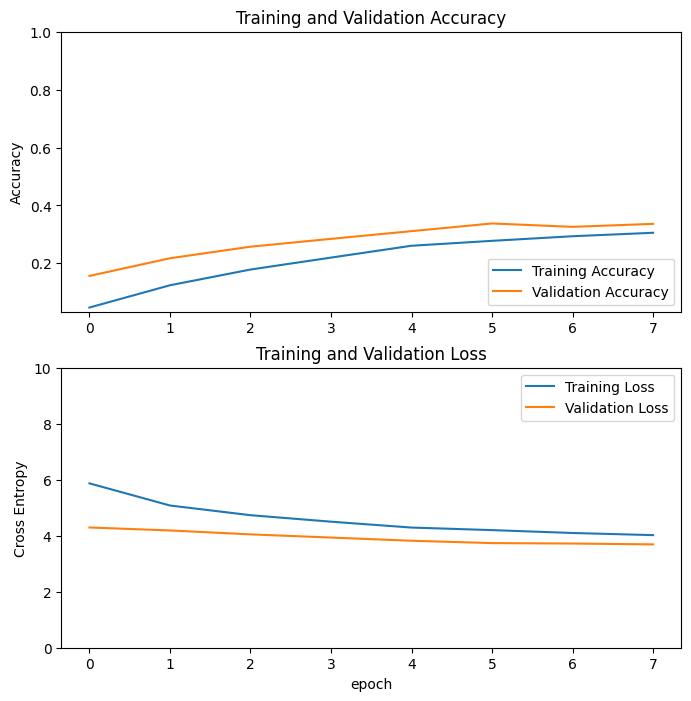

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
checkpoint_path = '/content/drive/MyDrive/Model/FinalEffnet_v2/effnet_phase1.keras'

# โหลดน้ำหนัก (Weights) กลับมา
print(f"⏳ Loading weights from {checkpoint_path}...")
try:
    model.load_weights(checkpoint_path)
    print("Load สำเร็จ!")
except Exception as e:
    print(f"Load ไม่ได้: {e}")

⏳ Loading weights from /content/drive/MyDrive/Model/FinalEffnet/effnet_phase1_head.keras...
Load สำเร็จ!


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Finetune

In [ ]:
base_model.trainable = True

optimizer_ft = tf.keras.optimizers.AdamW(learning_rate=5e-5, weight_decay=1e-4)

model.compile(optimizer=optimizer_ft,
              loss=loss_fn,
              metrics=["accuracy"])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 12, 12, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1792)           │         7,168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 196)            │       351,428 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,032,419 (68.79 MB)

 Trainable params: 17,903,628 (68.30 MB)

 Non-trainable params: 128,791 (503.09 KB)

In [ ]:
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=callbacks_phase2
)

save_history_pickle(history2, 'history_phase2.pkl')

Epoch 1/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 613s 1s/step - accuracy: 0.1532 - loss: 4.8500 - val_accuracy: 0.4148 - val_loss: 3.4697 - learning_rate: 5.0000e-05
Epoch 2/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - accuracy: 0.3579 - loss: 3.8114 - val_accuracy: 0.5158 - val_loss: 3.2163 - learning_rate: 5.0000e-05
Epoch 3/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 449s 1s/step - accuracy: 0.4854 - loss: 3.3889 - val_accuracy: 0.5798 - val_loss: 3.0600 - learning_rate: 5.0000e-05
Epoch 4/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - accuracy: 0.5805 - loss: 3.0815 - val_accuracy: 0.6187 - val_loss: 2.9316 - learning_rate: 5.0000e-05
Epoch 5/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 408s 1s/step - accuracy: 0.6513 - loss: 2.8963 - val_accuracy: 0.6527 - val_loss: 2.8511 - learning_rate: 5.0000e-05
Epoch 6/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.7016 - loss: 2.7535 - val_accuracy: 0.6773 - val_loss: 2.7749 - learning_rate: 5.0000e-05
Epoch 7/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 410s 1s/step - acc

In [ ]:
latest_checkpoint = '/content/drive/MyDrive/Model/FinalEffnet_v2/models/effnet_best_final.keras'

print(f"⏳ Loading model from: {latest_checkpoint}")
if os.path.exists(latest_checkpoint):
    model = tf.keras.models.load_model(latest_checkpoint)
    print("✅ Load สำเร็จ! พร้อมเทรนต่อ")
else:
    raise FileNotFoundError(f"ไม่เจอไฟล์: {latest_checkpoint} กรุณาเช็ค path อีกทีครับ")

⏳ Loading model from: /content/drive/MyDrive/Model/FinalEffnet_v2/models/effnet_best_final.keras
✅ Load สำเร็จ! พร้อมเทรนต่อ


In [ ]:
callbacks_resume = [
    EarlyStopping(patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint(latest_checkpoint, # เซฟทับไฟล์เดิมไปเลย
                    save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
    ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-7, verbose=1),
    CSVLogger('/content/drive/MyDrive/Model/FinalEffnet_v2/logs/log_phase2.csv', separator=',', append=True)
]

In [ ]:
LAST_EPOCH = 13 # <--- แก้เลขนี้ให้ตรงกับความจริง (คร่าวๆ ก็ได้)

# 5. สั่งเทรนต่อ!
print(f"🚀 Resuming training from Epoch {LAST_EPOCH+1}...")
history_resume = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=LAST_EPOCH, # บอกให้เริ่มนับต่อจากนี้
    epochs=40, # เป้าหมายเดิม
    callbacks=callbacks_resume
)

🚀 Resuming training from Epoch 14...
Epoch 14/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9009 - loss: 2.2492   
Epoch 14: val_accuracy improved from -inf to 0.77537, saving model to /content/drive/MyDrive/Model/FinalEffnet_v2/models/effnet_best_final.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 667s 1s/step - accuracy: 0.9009 - loss: 2.2491 - val_accuracy: 0.7754 - val_loss: 2.4817 - learning_rate: 5.0000e-05
Epoch 15/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.9207 - loss: 2.2074
Epoch 15: val_accuracy improved from 0.77537 to 0.77980, saving model to /content/drive/MyDrive/Model/FinalEffnet_v2/models/effnet_best_final.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - accuracy: 0.9207 - loss: 2.2074 - val_accuracy: 0.7798 - val_loss: 2.4604 - learning_rate: 5.0000e-05
Epoch 16/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - accuracy: 0.9162 - loss: 2.1798
Epoch 16: val_accuracy improved from 0.77980 to 0.78670, saving model to /content/drive/MyDrive/Model/FinalEffn

In [ ]:
latest_checkpoint = '/content/drive/MyDrive/Model/FinalEffnet_v2/models/effnet_best_final.keras'

print(f"⏳ Loading model from: {latest_checkpoint}")
if os.path.exists(latest_checkpoint):
    model = tf.keras.models.load_model(latest_checkpoint)
    print("✅ Load สำเร็จ! พร้อมเทรนต่อ")
else:
    raise FileNotFoundError(f"ไม่เจอไฟล์: {latest_checkpoint} กรุณาเช็ค path อีกทีครับ")

⏳ Loading model from: /content/drive/MyDrive/Model/FinalEffnet_v2/models/effnet_best_final.keras
✅ Load สำเร็จ! พร้อมเทรนต่อ


In [ ]:
callbacks_resume = [
    EarlyStopping(patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint(latest_checkpoint, # เซฟทับไฟล์เดิมไปเลย
                    save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
    ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-7, verbose=1),
    CSVLogger('/content/drive/MyDrive/Model/FinalEffnet_v2/logs/log_phase2.csv', separator=',', append=True)
]

In [ ]:
LAST_EPOCH = 19 # <--- แก้เลขนี้ให้ตรงกับความจริง (คร่าวๆ ก็ได้)

# 5. สั่งเทรนต่อ!
print(f"🚀 Resuming training from Epoch {LAST_EPOCH+1}...")
history_resume = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=LAST_EPOCH, # บอกให้เริ่มนับต่อจากนี้
    epochs=40, # เป้าหมายเดิม
    callbacks=callbacks_resume
)

🚀 Resuming training from Epoch 20...
Epoch 20/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9622 - loss: 2.0363   
Epoch 20: val_accuracy improved from -inf to 0.81675, saving model to /content/drive/MyDrive/Model/FinalEffnet_v2/models/effnet_best_final.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 635s 1s/step - accuracy: 0.9622 - loss: 2.0363 - val_accuracy: 0.8167 - val_loss: 2.3392 - learning_rate: 5.0000e-05
Epoch 21/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - accuracy: 0.9666 - loss: 2.0109
Epoch 21: val_accuracy improved from 0.81675 to 0.82020, saving model to /content/drive/MyDrive/Model/FinalEffnet_v2/models/effnet_best_final.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - accuracy: 0.9666 - loss: 2.0108 - val_accuracy: 0.8202 - val_loss: 2.3276 - learning_rate: 5.0000e-05
Epoch 22/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - accuracy: 0.9738 - loss: 1.9859
Epoch 22: val_accuracy improved from 0.82020 to 0.83153, saving model to /content/drive/MyDrive/Model/FinalEffn

## Model sanity check

In [ ]:
# -------------------------------
# Check model output shape
# -------------------------------
x_sample = tf.random.normal((1, IMG_SIZE, IMG_SIZE, 3))
y_pred = model(x_sample)
print("✅ Output shape:", y_pred.shape)
print("✅ Sum of softmax probabilities:", tf.reduce_sum(y_pred).numpy())
assert y_pred.shape[-1] == NUM_CLASSES

✅ Output shape: (1, 196)
✅ Sum of softmax probabilities: 1.0


Found 6114 files belonging to 196 classes.


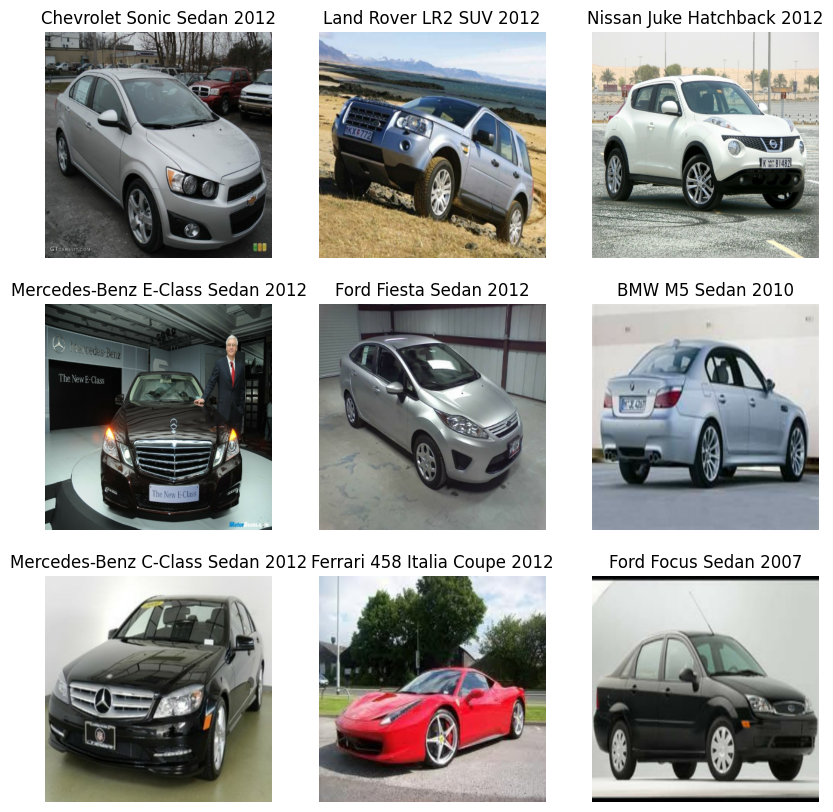

In [ ]:
train_ds_visual = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True
)

class_names = train_ds_visual.class_names
images, labels = next(iter(train_ds_visual))

plt.figure(figsize=(10, 10))
for i in range(min(9, len(images))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_idx = np.argmax(labels[i].numpy())
    plt.title(class_names[label_idx])
    plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step


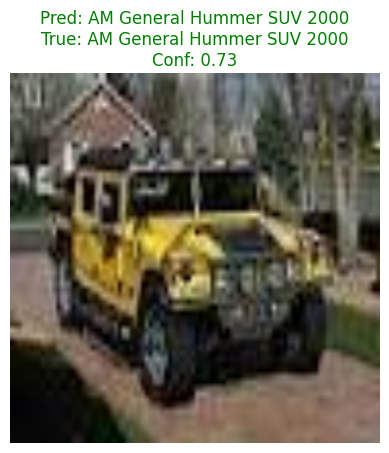

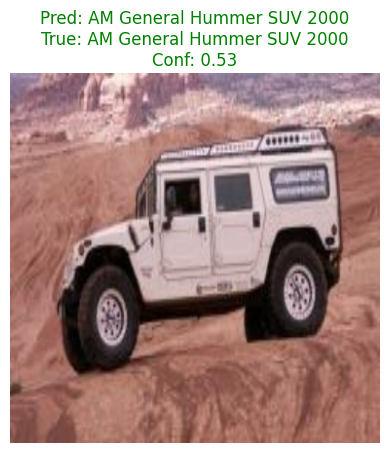

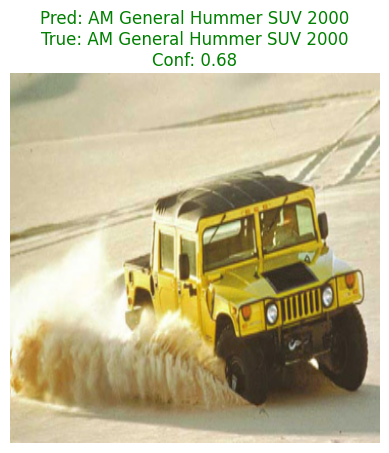

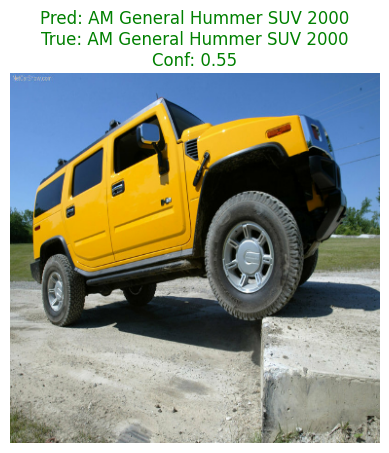

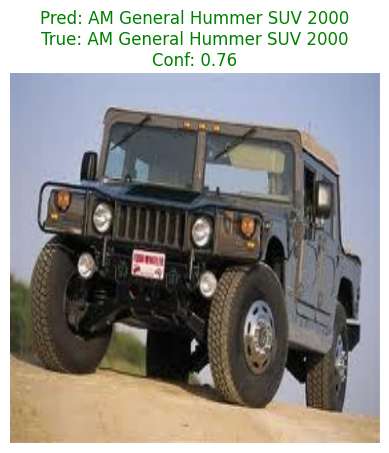

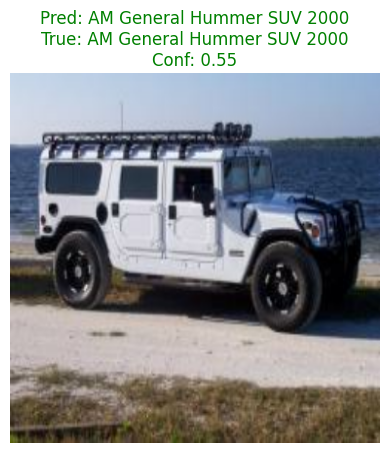

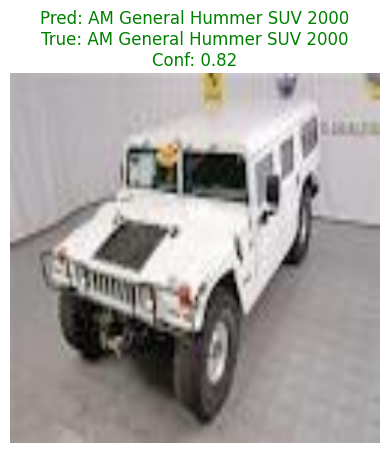

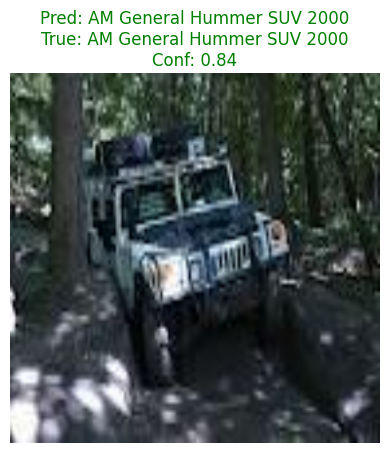

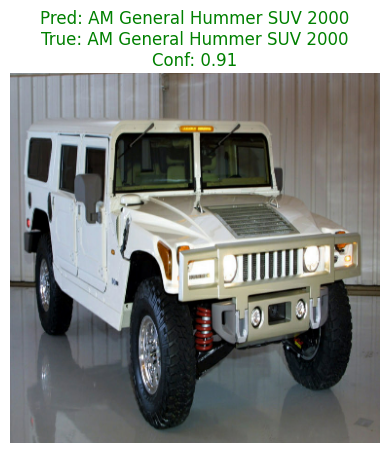

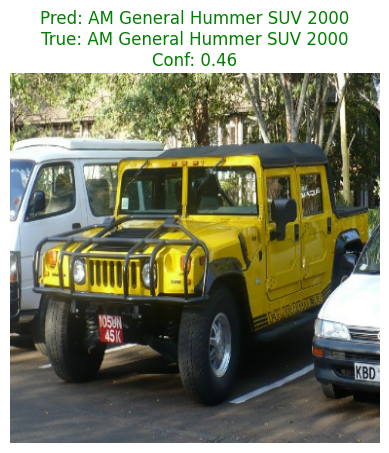

In [ ]:
# -------------------------------
# Predict batch แรก (sanity check)
# -------------------------------
# ใช้ train_ds หรือ test_ds preprocessed
images, labels = next(iter(test_ds))
preds = model.predict(images[:10])

for i in range(min(10, len(images))):
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    true_label = class_names[np.argmax(labels[i])]
    pred_label = class_names[np.argmax(preds[i])]
    confidence = np.max(preds[i])
    color = "green" if true_label == pred_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}\nConf: {confidence:.2f}", color=color)
    plt.show()

In [ ]:
# -------------------------------
# Check NaN / Inf weights
# -------------------------------
for layer in model.layers:
    for weight in layer.weights:
        w = weight.numpy()
        if np.isnan(w).any() or np.isinf(w).any():
            print(f"⚠️ พบ NaN/Inf ใน layer: {layer.name}")
print("✅ ไม่มี NaN/Inf ในโมเดล")

✅ ไม่มี NaN/Inf ในโมเดล


# Save Model

In [ ]:
save_path = '/content/drive/MyDrive/Model/FinalEffnet_v2/models/effnet_final_complete.keras'

# 1. สร้างโฟลเดอร์ก่อนเสมอ (กัน Error)
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# 2. เซฟโมเดล
model.save(save_path)
print(f"Model saved successfully at: {save_path}")

Model saved successfully at: /content/drive/MyDrive/Model/FinalEffnet_v2/models/effnet_final_complete.keras


# Evaluate

In [ ]:
# -------------------------------
# Evaluate บน test set
# -------------------------------
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")

503/503 ━━━━━━━━━━━━━━━━━━━━ 121s 240ms/step - accuracy: 0.8453 - loss: 2.2166
✅ Test Accuracy: 0.8760
✅ Test Loss: 2.1485


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

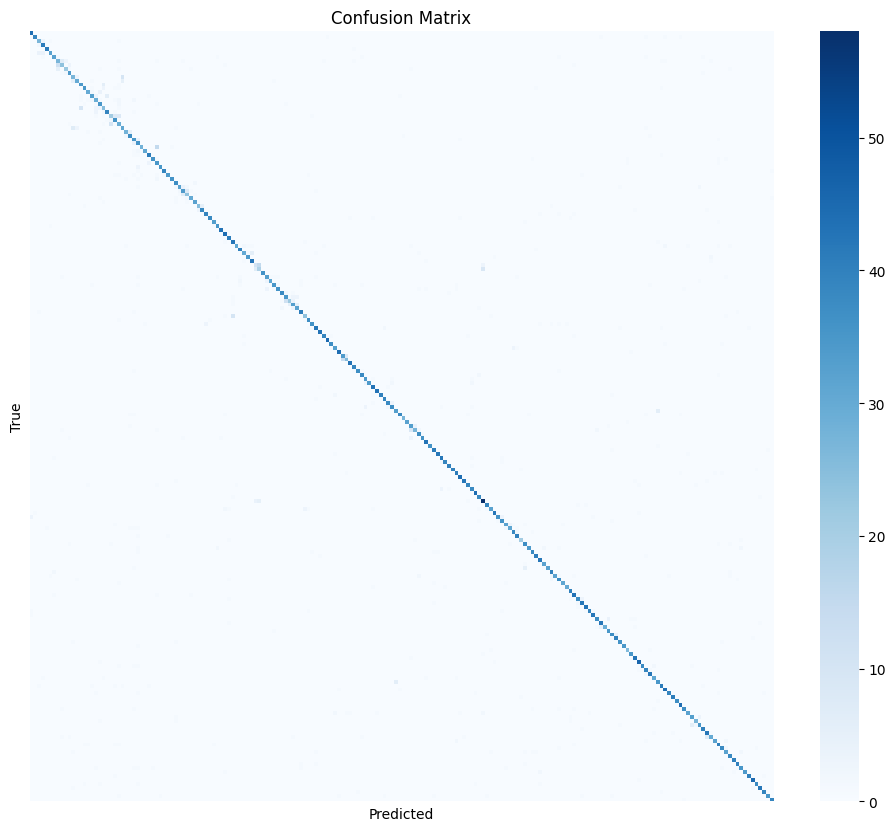

📄 Classification Report:
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.90      1.00      0.95        44
                             Acura Integra Type R 2001       0.97      0.89      0.93        44
                                   Acura RL Sedan 2012       0.77      0.84      0.81        32
                                   Acura TL Sedan 2012       0.82      0.95      0.88        43
                                  Acura TL Type-S 2008       0.98      0.98      0.98        42
                                  Acura TSX Sedan 2012       0.91      0.80      0.85        40
                              Acura ZDX Hatchback 2012       0.89      0.82      0.85        39
              Aston Martin V8 Vantage Convertible 2012       0.60      0.60      0.60        45
                    Aston Martin V8 Vantage Coupe 2012       0.67      0.59      0.62        41
              

In [ ]:
# -------------------------------
# Confusion Matrix + Classification Report
# -------------------------------
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues', xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
def plot_history_from_logs(log1_path, log2_path):
    """สร้างกราฟจากไฟล์ CSV Log"""

    # 1. เช็คไฟล์ก่อน
    if not os.path.exists(log1_path) or not os.path.exists(log2_path):
        print(f"❌ หาไฟล์ Log ไม่เจอ! กรุณาเช็ค Path:\n1. {log1_path}\n2. {log2_path}")
        return

    # 2. อ่านไฟล์ CSV
    try:
        df1 = pd.read_csv(log1_path)
        df2 = pd.read_csv(log2_path)
        print("✅ Loaded logs successfully!")
    except Exception as e:
        print(f"⚠️ Error reading CSV: {e}")
        return

    # 3. ดึงข้อมูล (รวมร่าง 2 เฟส)
    # หมายเหตุ: ถ้าใช้ append=True ข้อมูลใน df2 อาจจะมีหลายช่วงต่อกัน ซึ่งดีแล้ว
    acc = df1['accuracy'].tolist() + df2['accuracy'].tolist()
    val_acc = df1['val_accuracy'].tolist() + df2['val_accuracy'].tolist()
    loss = df1['loss'].tolist() + df2['loss'].tolist()
    val_loss = df1['val_loss'].tolist() + df2['val_loss'].tolist()

    epochs = range(1, len(acc) + 1)
    split_at = len(df1) # จุดจบ Phase 1

    # 4. พล็อตกราฟ
    plt.figure(figsize=(15, 6))

    # --- Accuracy ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Acc')
    plt.plot(epochs, val_acc, label='Validation Acc')
    plt.axvline(x=split_at, color='gray', linestyle='--', label='Start Fine-Tuning')

    # หาค่า Max มาโชว์
    max_acc = max(val_acc)
    plt.title(f'EfficientNetB4 Training (Max Val Acc: {max_acc*100:.2f}%)')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    # --- Loss ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.axvline(x=split_at, color='gray', linestyle='--', label='Start Fine-Tuning')

    plt.title('Training Loss')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    plt.show()

✅ Loaded logs successfully!


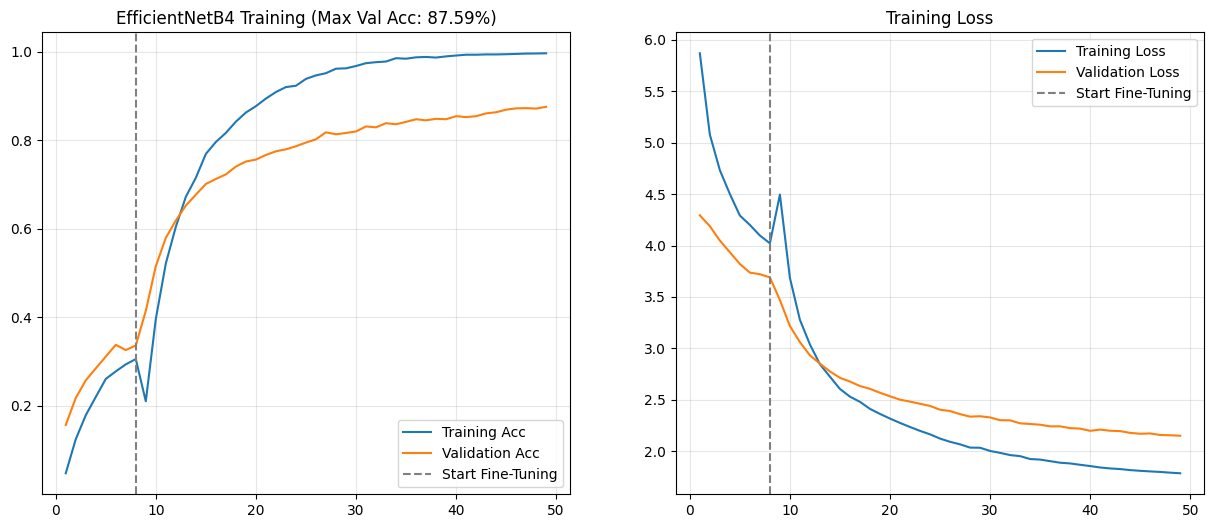

In [ ]:
# เรียกใช้งาน
path_log1 = os.path.join(LOG_DIR, 'log_phase1.csv')
path_log2 = os.path.join(LOG_DIR, 'log_phase2.csv')

plot_history_from_logs(path_log1, path_log2)

⏳ Loading best model: /content/drive/MyDrive/Model/FinalEffnet_v2/models/effnet_best_final.keras


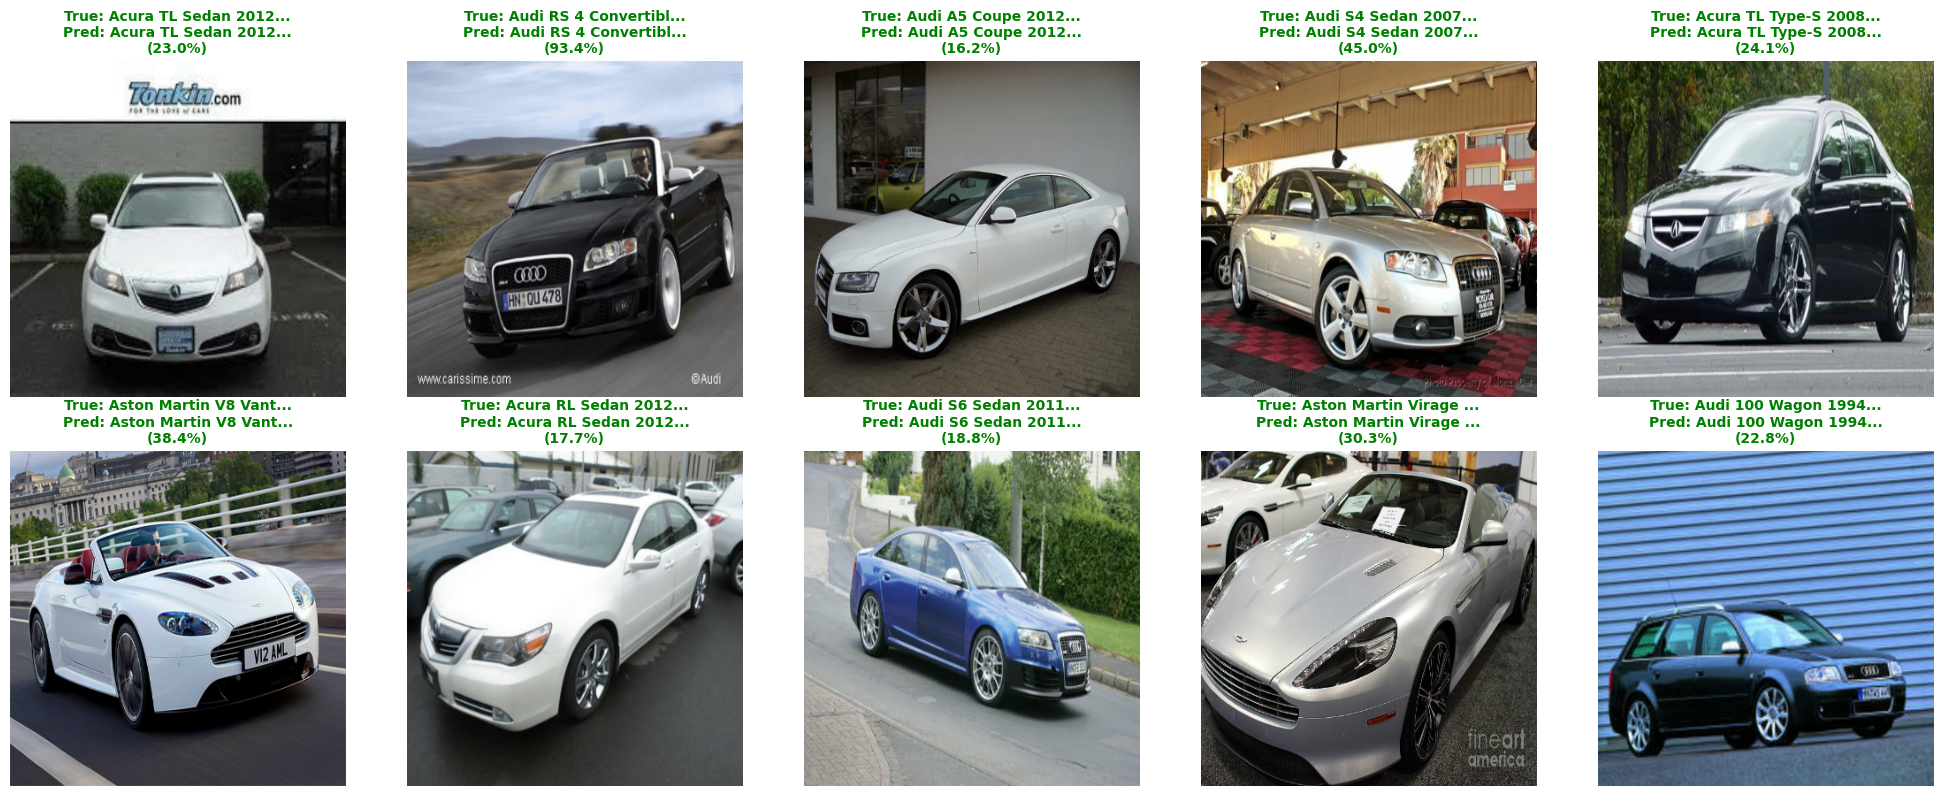

In [ ]:
best_model_path = os.path.join(MODEL_DIR, 'effnet_best_final.keras')
print(f"⏳ Loading best model: {best_model_path}")
final_model = tf.keras.models.load_model(best_model_path)

pool_images = []
pool_labels = []

# วนลูปดึงรูปมาสะสม (ดึงมาทีละ 1 รูป จากทุกๆ 3 Batch เพื่อให้คละกัน)
for i, (batch_imgs, batch_lbls) in enumerate(test_ds):
    if i % 3 == 0: # กระโดดข้าม Batch เพื่อให้ได้รถหลากหลายรุ่น
        # สุ่มหยิบ 1 รูปจากใน Batch นี้
        rand_idx = random.randint(0, len(batch_imgs) - 1)
        pool_images.append(batch_imgs[rand_idx])
        pool_labels.append(batch_lbls[rand_idx])

    # พอได้ครบสัก 20-30 รูปก็พอแล้ว (เยอะไปเดี๋ยวช้า)
    if len(pool_images) >= 20:
        break

# 3. สุ่มเลือกมา 10 รูปจากกองที่เราสะสมมา
indices = random.sample(range(len(pool_images)), min(10, len(pool_images)))

# 4. แสดงผล
plt.figure(figsize=(20, 8))

for i, idx in enumerate(indices):
    img = pool_images[idx]
    label = pool_labels[idx]

    # Predict
    img_input = tf.expand_dims(img, 0)
    pred = final_model.predict(img_input, verbose=0)

    # Decode Result
    true_idx = np.argmax(label)
    pred_idx = np.argmax(pred)
    true_name = class_names[true_idx]
    pred_name = class_names[pred_idx]
    conf = np.max(pred) * 100

    # Plot
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(img.numpy().astype("uint8"))

    col = "green" if true_idx == pred_idx else "red"

    # จัด Format ชื่อให้สั้นลงหน่อยถ้ามันยาวไป
    title = f"True: {true_name[:20]}...\nPred: {pred_name[:20]}...\n({conf:.1f}%)"
    plt.title(title, color=col, fontsize=10, fontweight='bold')
    plt.axis("off")

plt.tight_layout()
plt.show()

🔍 Top 10 Confusing Classes:
- Chevrolet Express Cargo Van 2007
- Audi TT Hatchback 2011
- Chevrolet Express Van 2007
- Chevrolet Silverado 1500 Hybrid Crew Cab 2012
- Aston Martin V8 Vantage Coupe 2012
- Audi S5 Coupe 2012
- Aston Martin V8 Vantage Convertible 2012
- BMW 6 Series Convertible 2007
- Ferrari 458 Italia Coupe 2012
- Chevrolet Tahoe Hybrid SUV 2012


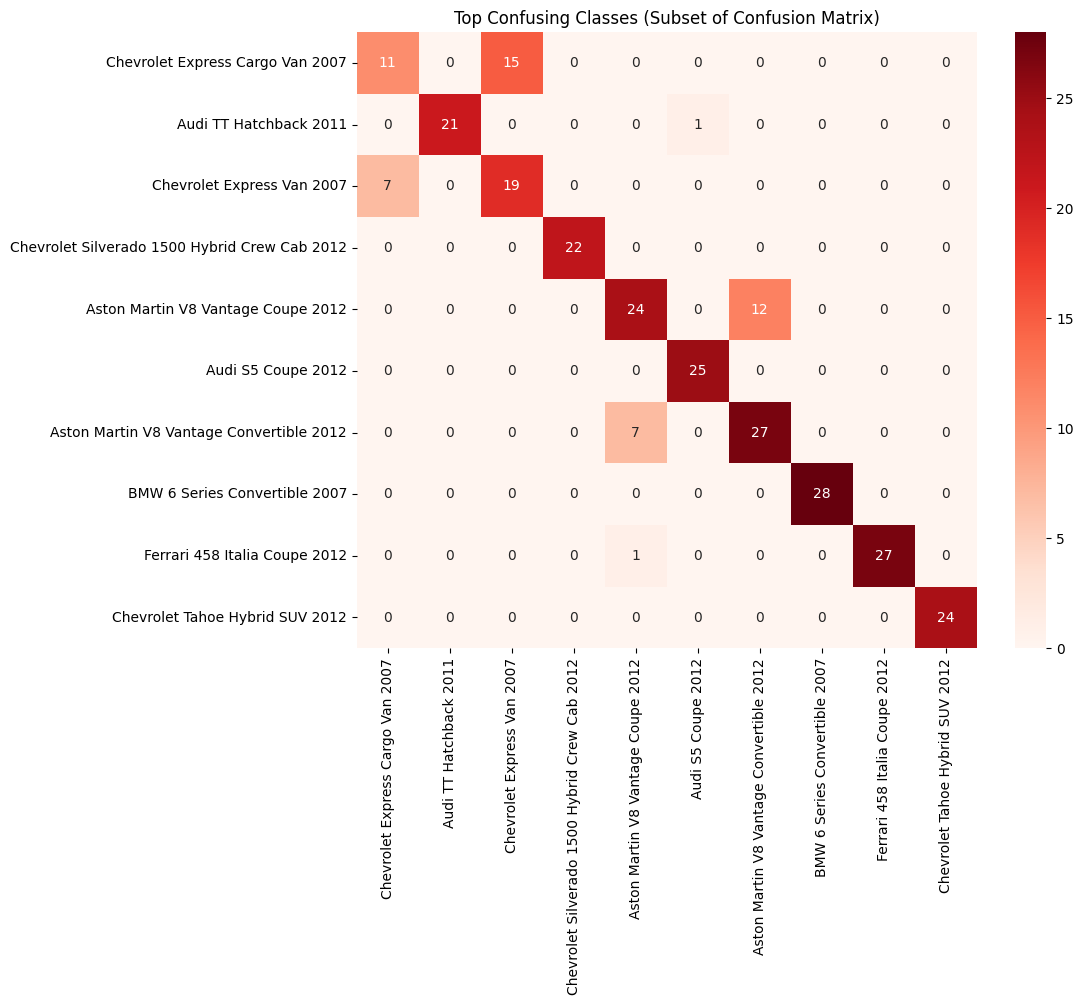

In [ ]:
# -------------------------------
# Top 10 confusing classes
# -------------------------------
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_sum[cm_sum == 0] = 1  # ป้องกันหารด้วย 0
cm_norm = cm.astype('float') / cm_sum
np.fill_diagonal(cm_norm, 0)
confused_scores = cm_norm.sum(axis=1)

top_confused = np.argsort(confused_scores)[-10:][::-1]

print("🔍 Top 10 Confusing Classes:")
for i in top_confused:
    print(f"- {class_names[i]}")

plt.figure(figsize=(10, 8))
sns.heatmap(cm[top_confused][:, top_confused],
            xticklabels=[class_names[i] for i in top_confused],
            yticklabels=[class_names[i] for i in top_confused],
            cmap="Reds", annot=True, fmt="d")
plt.title("Top Confusing Classes (Subset of Confusion Matrix)")
plt.show()